## Visualization of simulation data and comparison

In [94]:
### load module
%matplotlib notebook
#import instaseis
import numpy as np
import matplotlib.pyplot as plt
import h5py
#import obspy
# from obspy import read
# from obspy.taup import TauPyModel as taup
# from obspy.taup.taup_geo import calc_dist_azi as calc_dist_azi
# from obspy.clients.fdsn import Client
# from obspy.signal.cross_correlation import correlate
# from obspy.signal.cross_correlation import xcorr_max
# import pandas
# import gridspec as gridspec

# import seissolxdmf 

from pythonXdmfReader.pythonXdmfReader import *
import pyproj
import scipy.io as sio
import matplotlib.tri as tri
# from mpl_toolkits.basemap import Basemap
from scipy import spatial
from netCDF4 import Dataset

import seaborn as sns

c_blue=['#2878B5','#9AC9DB'];
c_red=['#C82423','#F8AC8C','#FF8884'];
c_gre=['#96C37D','#8ECFC9'];
c_pur=['#8B8EFE','#C497B2'];

colors2=sns.color_palette("rocket",8);
print('load modulus')

load modulus


In [3]:
# load contour data and plot

# from netCDF4 import Dataset

# fin = Dataset('mesh/alu_60_7.nc','r')
# print(fin)
# x = fin.variables['x'][:]
# y = fin.variables['y'][:]
# z = fin.variables['z'][:,:]

# xgrid,ygrid = np.meshgrid(x,y)
# # plt.figure()
# # plt.contour(xgrid,ygrid,z)

# lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
# myproj = pyproj.Proj(proj='geocent', init='EPSG:5936',ellps='WGS84', datum='WGS84')

# xxx = pyproj.transform(lla, myproj, xgrid,ygrid, xgrid, radians=False)

# fig,ax = plt.subplots(figsize=(4,3.5))
# plt.contour(xxx[0]/1e3,xxx[1]/1e3,z)

# ax.set_xlim(0.9e3, 1.8e3)
# ax.set_ylim(-2.5e3,-1.4e3)


In [95]:
# load surface static GPS displacement and compare

modelname = 'alkR057-TP70c'
# foldername = 'resultNew/'
foldername = '/import/deadlock-data/dli/Alaska2021/resultNew/'

lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
myproj = pyproj.Proj( init='EPSG:5936',ellps='WGS84', datum='WGS84')

# xdmfFilename = foldername + modelname+'-surface.xdmf'
gpsfolder='GPS/'
stall = np.loadtxt(gpsfolder+'/gnss_station2.txt')
staxyz = pyproj.transform(lla, myproj, stall[:,0],stall[:,1], stall[:,1], radians=False)

# stall2 = np.loadtxt('vno_stations2.dat')
# staxyz2= pyproj.transform(lla, myproj, stall2[:,1],stall2[:,0], stall2[:,1], radians=False)

## plot mapview of GPS records
coastf = 'coastline/alaska.mat'
coast = sio.loadmat(coastf)

hypoll = np.loadtxt('hypocenters/hypocenters.dat')
hypoxyz =  pyproj.transform(lla, myproj,hypoll[:,0],hypoll[:,1],radians=False)

/home/dli/anaconda3/envs/obspy/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_11419/3222223205.py:13: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  staxyz = pyproj.transform(lla, myproj, stall[:,0],stall[:,1], stall[:,1], radians=False)
/tmp/ipykernel_11419/3222223205.py:23: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  hypoxyz =  pyproj.transform(lla, myproj,hypoll[:,0],hypoll[:,1],radians=False)


In [56]:
# find stations and read records
xdmfFilename = foldername + modelname+'-surface.xdmf'
# 
surfxyz = ReadGeometry(xdmfFilename)
connect = ReadConnect(xdmfFilename)
ndt = ReadNdt(xdmfFilename)

triang = tri.Triangulation(surfxyz[:,0]/1000,surfxyz[:,1]/1000,connect)
flonlat =  pyproj.transform(myproj,lla,surfxyz[:,0],surfxyz[:,1],radians=False)
triang2 = tri.Triangulation(flonlat[0],flonlat[1],connect)

centers = (surfxyz[connect[:,0]] + surfxyz[connect[:,1]] + surfxyz[connect[:,2]])/3.
Receiver = np.array([staxyz[0],staxyz[1],staxyz[2]])
Receiver = Receiver.transpose()

# search for nearest points of stations
tree = spatial.KDTree(centers)
dist, ids = tree.query(Receiver)

FidReceiversnew = gpsfolder+'/'+modelname+'/GPS_xyz.txt'
fout = open(FidReceiversnew,'w')
fout1 = open(gpsfolder+'/'+ modelname +'/GPS_number.txt','w')

for k in range(0,stall[:,0].size):
        #newrec = find_nearest_vector(centers, rec)
        newrec=centers[ids[k]]
        fout.write("%f %f %f\n" %(newrec[0],newrec[1],newrec[2]))
        fout1.write("%d %f\n" %(ids[k],dist[k]))
fout.close()
fout1.close()

## read records
sta = np.loadtxt(gpsfolder+modelname+'/GPS_number.txt')
sta = sta[:,0]
nsta = sta.size
vec = np.array([])
xyz = np.array([])

for ista in range(0,nsta):
    uu = LoadData(xdmfFilename,'U',1,idt=ndt-1,oneDtMem=True,firstElement=np.int(sta[ista]))
    vv = LoadData(xdmfFilename,'V',1,idt=ndt-1,oneDtMem=True,firstElement=np.int(sta[ista]))
    ww = LoadData(xdmfFilename,'W',1,idt=ndt-1,oneDtMem=True,firstElement=np.int(sta[ista]))
    slp1 = uu[0][0]
    slp2 = vv[0][0]
    slp3 = ww[0][0]
    vec = np.append(vec,[slp1,slp2,slp3])

np.savetxt(gpsfolder+modelname+'/GPS_vec.txt',vec)


# plot GPS vector
model = np.loadtxt('GPS/'+ modelname +'/GPS_vec.txt')  ;
data = np.loadtxt('GPS/gnss_station2.txt') ;
obv = np.loadtxt('GPS/gnss_data.txt');

#staxyz = pyproj.transform(lla, myproj, data[:,0],data[:,1], radians=False)
ncst = pyproj.transform(lla, myproj, coast['data'][:,0],coast['data'][:,1], radians=False)

# obvx = staxyz[0]/1e3
# obvy = staxyz[1]/1e3
obvx = stall[:,0]
obvy = stall[:,1]
#%%
slpz = LoadData(xdmfFilename,'W',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
slpy = LoadData(xdmfFilename,'V',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
slpx = LoadData(xdmfFilename,'U',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
slp = np.sqrt(slpy[0]*slpy[0]+slpx[0]*slpx[0])

/tmp/ipykernel_11419/150309155.py:9: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  flonlat =  pyproj.transform(myproj,lla,surfxyz[:,0],surfxyz[:,1],radians=False)
/tmp/ipykernel_11419/150309155.py:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  uu = LoadData(xdmfFilename,'U',1,idt=ndt-1,oneDtMem=True,firstElement=np.int(sta[ista]))
/tmp/ipykernel_11419/150309155.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To si

<IPython.core.display.Javascript object>


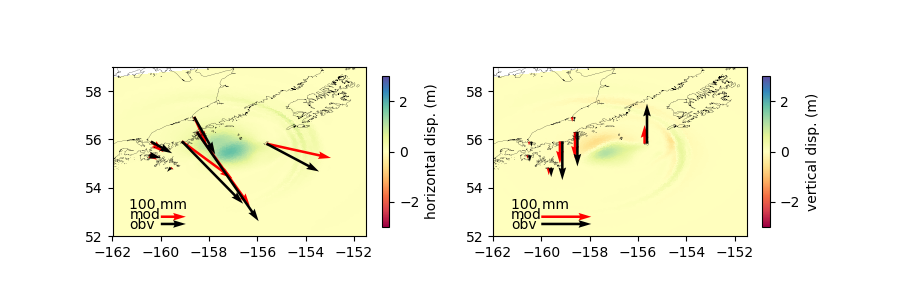

In [57]:
#%% plot GPS displacement
fig,([ax2,ax3])=plt.subplots(ncols=2,nrows=1,figsize=(9,3))

sns.color_palette("Spectral", as_cmap=True)

#sc = ax0.tripcolor(triang,td[0]/1e6,cmap='seismic',shading='flat')
sc = ax2.tripcolor(triang2,slp,cmap='Spectral',shading='flat',vmin=-3.0,vmax=3.0)
cl = fig.colorbar(sc,ax=ax2,shrink=0.65)
cl.set_label('horizontal disp. (m)')
#
# ax2.set(xlim=(0.90e3, 1.8e3),ylim=(-2.5e3,-1.4e3))
# ax2.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.5)
# ax2.plot(hypoll[1,0],hypoll[1,1],'*k',markersize=5)
ax2.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.15)
ax2.set(xlim=(-162, -151.5),ylim=(52,59))
# ax2.set_title('Simulation')
ax2.set_yticks([52,54,56,58])
# ax2.contour(xxx[0]/1e3,xxx[1]/1e3,z)
ax2.set_aspect(1)

ax2.quiver(np.append(obvx,-160),np.append(obvy,52.8),np.append(model[0::3]*1000,100),np.append(model[1::3]*1000,0),
           scale=400,scale_units='inches',color='red',width=0.010)

ax2.quiver(np.append(obvx,-160),np.append(obvy,52.5),np.append(obv[:,2]*1000,100),np.append(obv[:,3]*1000,0),
           scale=400,scale_units='inches',color='black',width=0.010)

ax2.text(-161.3,53.1,'100 mm')
ax2.text(-161.3,52.7,'mod')
ax2.text(-161.3,52.3,'obv')
# ax2.text(1.1e3,-2.3e3,'100 mm')
# ax2.text(1.25e3,-2.34e3,'mod')
# ax2.text(1.25e3,-2.38e3,'obv')

##     ax2.set_title('Mapview of GPS vector ')

sc = ax3.tripcolor(triang2,slpz[0],cmap='Spectral',shading='flat',vmax=3.0,vmin=-3.0)
cl = fig.colorbar(sc,ax=ax3,shrink=0.65)
cl.set_label('vertical disp. (m)')
##
# ax3.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.5)
# ax3.set(xlim=(0.9e3, 1.8e3),ylim=(-2.5e3,-1.4e3))
# ax3.plot(hypoll[:,0],hypoll[:,1],'*r',markersize=5)
ax3.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.15)
ax3.set(xlim=(-162, -151.5),ylim=(52,59))
# ax3.set_title('Simulation')
ax3.set_yticks([52,54,56,58])
# ax3.contour(xxx[0]/1e3,xxx[1]/1e3,z)

ax3.quiver(np.append(obvx-0.1,-160),np.append(obvy,52.8),np.append(model[2::3]-model[2::3],100),np.append(model[2::3]*1000,0),
           scale=200,scale_units='inches',color='red',width=0.010)
#
ax3.quiver(np.append(obvx,-160),np.append(obvy,52.5),np.append(obv[:,3]-obv[:,3],100),np.append(obv[:,4]*1000,0),
           scale=200,scale_units='inches',color='black',width=0.010)
#
ax3.text(-161.25,53.1,'100 mm')
ax3.text(-161.25,52.7,'mod')
ax3.text(-161.25,52.3,'obv')
ax3.set_aspect(1)

outname = './'+ modelname +'-gps.png'
plt.savefig(outname,dpi=250,transparent=False)


In [21]:
fin = open( 'surface_deformation.disp','r')
sdisp = np.loadtxt(fin,comments='#',skiprows=1)

surfxyz = pyproj.transform(lla, myproj, sdisp[:,0],sdisp[:,1], sdisp[:,1],radians=False)

# fig,([ax2,ax3])=plt.subplots(ncols=2,nrows=1,figsize=(9,6))
plt.figure(figsize=(7,8))

ax2=plt.subplot(321)
ax2.scatter(surfxyz[0]/1e3,surfxyz[1]/1e3,c=sdisp[:,3],cmap='Spectral',vmin=-1.0,vmax=1.0)
ax2.set(xlim=(1.e3, 1.9e3),ylim=(-2.4e3,-1.4e3))
ax2.set_ylabel('E component')
ax2.set_title('Inversion')
ax2.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.2)
ax2.xaxis.set_ticklabels([])
ax2.set_aspect(1)

ax3=plt.subplot(322)
sc = ax3.tripcolor(triang,slpx[0],cmap='Spectral',shading='flat',vmin=-1.0,vmax=1.0)
ax3.set(xlim=(1.e3, 1.9e3),ylim=(-2.4e3,-1.4e3))
ax3.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.2)
ax3.set_title('Simulation')
ax3.yaxis.set_ticklabels([])
ax3.xaxis.set_ticklabels([])
ax3.set_aspect(1)

ax2=plt.subplot(323)
ax2.scatter(surfxyz[0]/1e3,surfxyz[1]/1e3,c=sdisp[:,4],cmap='Spectral',vmin=-1.0,vmax=1.0)
ax2.set(xlim=(1.e3, 1.9e3),ylim=(-2.4e3,-1.4e3))
ax2.set_ylabel('N component')
ax2.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.2)
ax2.xaxis.set_ticklabels([])
ax2.set_aspect(1)

ax3=plt.subplot(324)
sc = ax3.tripcolor(triang,slpy[0],cmap='Spectral',shading='flat',vmin=-1.0,vmax=1.0)
ax3.set(xlim=(1.e3, 1.9e3),ylim=(-2.4e3,-1.4e3))
ax3.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.2)
ax3.yaxis.set_ticklabels([])
ax3.xaxis.set_ticklabels([])
ax3.set_aspect(1)

ax2=plt.subplot(325)
ax2.scatter(surfxyz[0]/1e3,surfxyz[1]/1e3,c=sdisp[:,5],cmap='Spectral',vmin=-1.0,vmax=1.0)
ax2.set(xlim=(1.e3, 1.9e3),ylim=(-2.4e3,-1.4e3))
ax2.set_ylabel('U component')
ax2.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.2)
ax2.set_aspect(1)

ax3=plt.subplot(326)
sc = ax3.tripcolor(triang,slpz[0],cmap='Spectral',shading='flat',vmin=-1.0,vmax=1.0)
ax3.set(xlim=(1.e3, 1.9e3),ylim=(-2.4e3,-1.4e3))
ax3.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.2)
ax3.yaxis.set_ticklabels([])
ax3.set_aspect(1)

plt.show()


outname = './'+ modelname +'-surfxyz.png'
plt.savefig(outname,dpi=150,transparent=False)


<ipython-input-21-8d8dd4d4eab8>:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  surfxyz = pyproj.transform(lla, myproj, sdisp[:,0],sdisp[:,1], sdisp[:,1],radians=False)


<IPython.core.display.Javascript object>

ValueError: Length of color values array must be the same as either the number of triangulation points or triangles

<IPython.core.display.Javascript object>


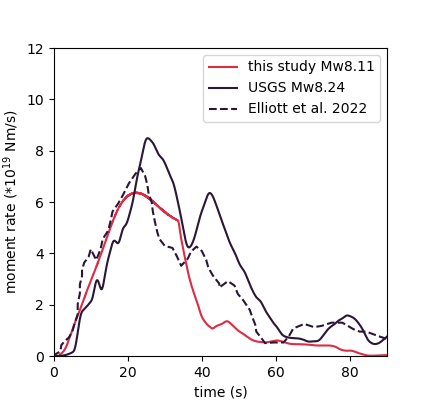

In [53]:
# plot moment rate and compare
modelname = 'alkR057-TP72f'
foldername = '/import/deadlock-data/dli/Alaska2021/resultNew/'

# modelname = 'tp46'
# foldername = 'AlaskaTP46/output/'

fin = open(foldername + modelname+'-EnF_0t-all.dat','r')
enf = np.loadtxt(fin,comments='#',skiprows=1)

mfile='STF_usgs.txt'
mfile='mr_2.dat'

fin2 = open(mfile,'r')
mr = np.loadtxt(fin2)

fin3 = open('STF_elliott.txt','r')
mr3 = np.loadtxt(fin3)

moment0 = 0.0
M0 = np.trapz(enf[:,1], x=enf[:,0])
mag  = 2/3*np.log10(M0)-6.07


plt.figure(figsize=(4.3,4))

ax0=plt.subplot(111)               
plt.plot(enf[:,0],enf[:,1]*1e7/1e26,'-',color=colors2[4])   # from MPa*m**2/s to dyne-cm/s
plt.plot(mr[:,0],mr[:,1]/1e19,'-',color=colors2[0]) # normalized by 1e19
plt.plot(mr3[:,0],mr3[:,1],'--',color=colors2[0])
plt.legend(['this study'+ ' Mw'+str(round(mag,2)),'USGS Mw8.24','Elliott et al. 2022'])

plt.xlabel('time (s)')
plt.ylabel('moment rate (*$10^{19}$ Nm/s)')
ax0.set(xlim=(0,90),ylim=(0,12))

# seismic moment magnitude


# plt.text(6,9,'Mw'+str(round(mag,2)),color=colors2[5])
plt.savefig(modelname+'-mag.png',dpi=150)

In [11]:
fnet = Dataset('Kinematic/2021_Chignik_FFM_slip_grd.nc','r')
# print(fnet.variables)
lon_2022 = fnet['lon']
lat_2022 = fnet['lat']
slip_2022 = fnet['z'][:,:]

data = sio.loadmat('Kinematic/usgs_slip.mat')
lon_usgs= data['data']['lon'][0,0]
lat_usgs= data['data']['lat'][0,0]
slip_usgs= data['data']['slip'][0,0]
# print(slip_2022.shape)

hypoll = np.loadtxt('hypocenters/hypocenters.dat')
hypoll4 = np.loadtxt('hypocenters/hypocenters4.dat')


In [7]:
print(np.max(xyz[:,0]))
print(np.min(xyz[:,0]))
print(np.max(xyz[:,1]))
print(np.min(xyz[:,1]))



1689464.123441935
1356560.74280239
-1749015.0552473797
-2065564.5919320022


In [6]:
np.max(asl[0])

289.57122081872217

/home/dli/anaconda3/envs/obspy/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_11419/3393192698.py:19: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  flonlat =  pyproj.transform(myproj,lla,xyz[:,0],xyz[:,1],radians=False)


<IPython.core.display.Javascript object>


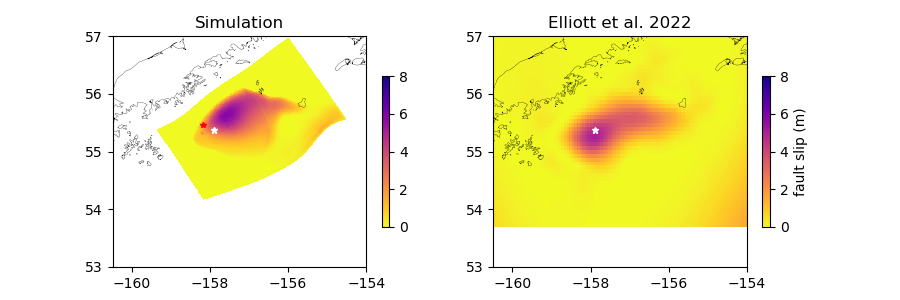

In [61]:
# load USGS  fault slip model

modelname = 'alkR057-TP72f'
# foldername = 'resultNew/'

hypo2 = np.loadtxt('hypocenters/hypocenters2.dat')

# print(slip_usgs.shape)
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
myproj = pyproj.Proj( init='EPSG:5936',ellps='WGS84', datum='WGS84')

xdmfFilename = foldername + modelname+'-fault.xdmf'
ndt = ReadNdt(xdmfFilename)

# ndt=90
xyz = ReadGeometry(xdmfFilename)
connect = ReadConnect(xdmfFilename)

flonlat =  pyproj.transform(myproj,lla,xyz[:,0],xyz[:,1],radians=False)
triang = tri.Triangulation(flonlat[0],flonlat[1],connect)

asl= LoadData(xdmfFilename,'ASl',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)

fig,([ax0,ax1])=plt.subplots(nrows=1,ncols=2,figsize=(9,3))

#ax0.set_title('Mapview of Td0')
sc = ax0.tripcolor(triang,asl[0],cmap='plasma_r',shading='flat',vmin=0.0,vmax=8.0)
ax0.plot(hypoll[5,0],hypoll[5,1],'*',color='red',markersize=4)
ax0.plot(hypoll[0,0],hypoll[0,1],'*',color='white',markersize=5)
# ax0.plot(hypo2[0,0],hypo2[0,1],'*',color='blue',markersize=5)

ax0.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.2)
ax0.set(xlim=(-160.5, -154),ylim=(53.5,57))
ax0.set_title('Simulation')
ax0.set_yticks([53,54,55,56,57])
# ax0.set_aspect(1)

cl = fig.colorbar(sc,ax=ax0,shrink=0.65)

# sc = ax1.pcolor(lon_usgs,lat_usgs,slip_usgs[1::,1::],cmap='plasma_r',shading='flat',vmin=0.0,vmax=8.0)
sc = ax1.pcolor(lon_2022,lat_2022,slip_2022[1::,1::],cmap='plasma_r',shading='flat',vmin=0.0,vmax=8.0)

# ax1.set(xlim=(1.2e3, 1.75e3),ylim=(-2.2e3,-1.6e3))
ax1.set(xlim=(-160.5,-154),ylim=(53.5,57))
cl = fig.colorbar(sc,ax=ax1,shrink=0.65)

ax1.plot(hypoll[0,0],hypoll[0,1],'*',markersize=5,color='white')
ax1.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.2)
ax1.set_title('Elliott et al. 2022')
cl.set_label('fault slip (m)')
ax1.set_yticks([53,54,55,56,57])
# ax1.set_aspect(1)

outname = modelname+'-slip2.png'
plt.savefig(outname,dpi=200,transparent=False)

In [25]:
# print(flonlat[0],flonlat[1])

[-157.86250041 -157.86750042 -157.80000048 ... -157.11250049 -157.26500092
 -157.08750051] [54.72250005 54.72250005 54.71500002 ... 55.74250011 55.80000032
 55.75250011]


/tmp/ipykernel_5867/3305806374.py:13: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  hypoxyz =  pyproj.transform(lla, myproj,hypoll[:,0],hypoll[:,1],radians=False)
/tmp/ipykernel_5867/3305806374.py:21: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  flonlat =  pyproj.transform(myproj,lla,xyz[:,0],xyz[:,1],radians=False)


<IPython.core.display.Javascript object>


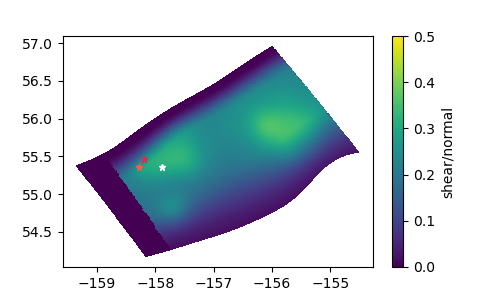

/tmp/ipykernel_5867/3305806374.py:59: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  hypoxyz =  pyproj.transform(lla, myproj,hypoll[:,0],hypoll[:,1],radians=False)
/tmp/ipykernel_5867/3305806374.py:67: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  flonlat =  pyproj.transform(myproj,lla,xyz[:,0],xyz[:,1],radians=False)


<IPython.core.display.Javascript object>


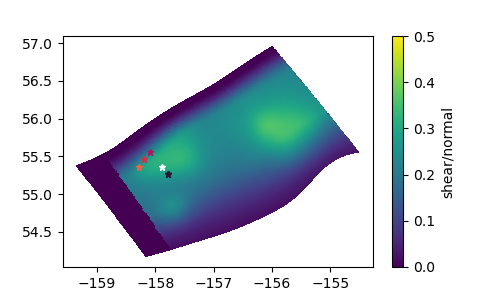

NameError: name 'coast' is not defined

In [7]:
# plot parameters
# staloc = np.loadtxt('vno_station_mesh3.xyz')

modelname = 'alkR057-TP64'
# foldername = 'resultNew/'
foldername = '/import/deadlock-data/dli/Alaska2021/resultNew/'

hypoll = np.loadtxt('hypocenters.dat')
hypoll4 = np.loadtxt('hypocenters4.dat')

fr = np.loadtxt('faultreceivers.dat')

hypoxyz =  pyproj.transform(lla, myproj,hypoll[:,0],hypoll[:,1],radians=False)

xdmfFilename = foldername + modelname+'-fault.xdmf'

ndt = ReadNdt(xdmfFilename)
xyz = ReadGeometry(xdmfFilename)
connect = ReadConnect(xdmfFilename)

flonlat =  pyproj.transform(myproj,lla,xyz[:,0],xyz[:,1],radians=False)
triang = tri.Triangulation(flonlat[0],flonlat[1],connect)
#%%
pn0= LoadData(xdmfFilename,'Pn0',connect.shape[0],idt=0,oneDtMem=True,firstElement=-1)
td0 =LoadData(xdmfFilename,'Td0',connect.shape[0],idt=0,oneDtMem=True,firstElement=-1)

S = ((0.6*-pn0[0])-td0[0])/((0.1*pn0[0])+td0[0])


fig,ax0=plt.subplots(nrows=1,ncols=1,figsize=(5,3))


sc = ax0.tripcolor(triang,td0[0]/-pn0[0],cmap='viridis',shading='flat',vmin=0,vmax=0.5)
cl = fig.colorbar(sc,ax=ax0)
cl.set_label('shear/normal')
ax0.plot(hypoll[0,0],hypoll[0,1],'*w',markersize=5)
ax0.plot(hypoll[4,0],hypoll[4,1],'*',c=colors2[5],markersize=5)
ax0.plot(hypoll[5,0],hypoll[5,1],'*',c=colors2[4],markersize=5)
# plot parameters
# staloc = np.loadtxt('vno_station_mesh3.xyz')

modelname = 'alkR057-TP64'
# foldername = 'resultNew/'
foldername = '/import/deadlock-data/dli/Alaska2021/resultNew/'

hypoll = np.loadtxt('hypocenters.dat')
hypoll4 = np.loadtxt('hypocenters4.dat')

fr = np.loadtxt('faultreceivers.dat')

hypoxyz =  pyproj.transform(lla, myproj,hypoll[:,0],hypoll[:,1],radians=False)

xdmfFilename = foldername + modelname+'-fault.xdmf'

ndt = ReadNdt(xdmfFilename)
xyz = ReadGeometry(xdmfFilename)
connect = ReadConnect(xdmfFilename)

flonlat =  pyproj.transform(myproj,lla,xyz[:,0],xyz[:,1],radians=False)
triang = tri.Triangulation(flonlat[0],flonlat[1],connect)
#%%
pn0= LoadData(xdmfFilename,'Pn0',connect.shape[0],idt=0,oneDtMem=True,firstElement=-1)
td0 =LoadData(xdmfFilename,'Td0',connect.shape[0],idt=0,oneDtMem=True,firstElement=-1)

S = ((0.6*-pn0[0])-td0[0])/((0.1*pn0[0])+td0[0])


fig,ax0=plt.subplots(nrows=1,ncols=1,figsize=(5,3))

sc = ax0.tripcolor(triang,td0[0]/-pn0[0],cmap='viridis',shading='flat',vmin=0,vmax=0.5)
cl = fig.colorbar(sc,ax=ax0)
cl.set_label('shear/normal')
ax0.plot(hypoll[0,0],hypoll[0,1],'*w',markersize=5)
ax0.plot(hypoll[4,0],hypoll[4,1],'*',c=colors2[5],markersize=5)
ax0.plot(hypoll[5,0],hypoll[5,1],'*',c=colors2[4],markersize=5)

# ax0.plot(hypoll[2,0],hypoll[2,1],'*',c=colors2[2],markersize=5)
ax0.plot(hypoll[3,0],hypoll[3,1],'*',c=colors2[3],markersize=5)
ax0.plot(hypoll4[:,0],hypoll4[:,1],'*',c=colors2[0],markersize=5)


ax0.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.3)
ax0.set(xlim=(-160.5, -154),ylim=(53.5,57))
ax0.set_yticks([53,54,55,56,57])


outname = modelname+'-para.png'
plt.savefig(outname,dpi=200,transparent=False)

# ax0.plot(hypoll[2,0],hypoll[2,1],'*',c=colors2[2],markersize=5)
ax0.plot(hypoll[3,0],hypoll[3,1],'*',c=colors2[3],markersize=5)


ax0.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.3)
ax0.set(xlim=(-160.5, -154),ylim=(53.5,57))
ax0.set_yticks([53,54,55,56,57])

# ax1.set_yticks([53,54,55,56,57])
outname = modelname+'-para.png'
plt.savefig(outname,dpi=200,transparent=False)


/tmp/ipykernel_11419/3662049865.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  hypoxyz =  pyproj.transform(lla, myproj,hypoll[:,0],hypoll[:,1],radians=False)


<IPython.core.display.Javascript object>


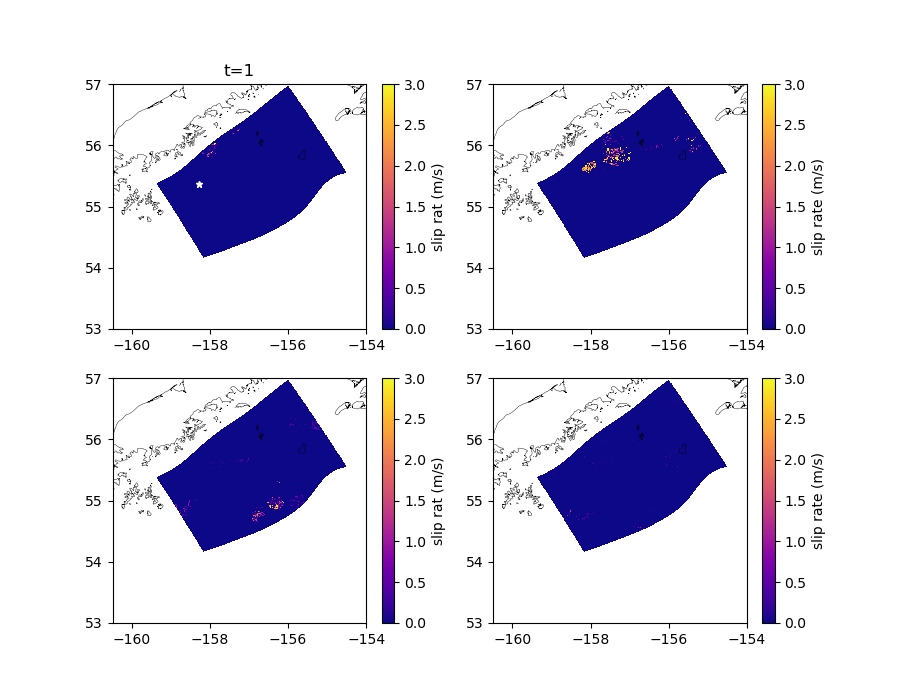

In [21]:
# plot parameters
# staloc = np.loadtxt('vno_station_mesh3.xyz')

modelname = 'alkR057-TP70b'
# oldername = 'resultNew/'

# hypoll = np.loadtxt('hypocenters.dat')
# fr = np.loadtxt('faultreceivers.dat')

hypoxyz =  pyproj.transform(lla, myproj,hypoll[:,0],hypoll[:,1],radians=False)

xdmfFilename = foldername + modelname+'-fault.xdmf'

# ndt = ReadNdt(xdmfFilename)
# xyz = ReadGeometry(xdmfFilename)
connect = ReadConnect(xdmfFilename)

# triang = tri.Triangulation(xyz[:,0]/1000,xyz[:,1]/1000,connect)

#%%
sr0= LoadData(xdmfFilename,'SRd',connect.shape[0],idt=1,oneDtMem=True,firstElement=-1)
sr1 =LoadData(xdmfFilename,'SRd',connect.shape[0],idt=4,oneDtMem=True,firstElement=-1)
sr2= LoadData(xdmfFilename,'SRd',connect.shape[0],idt=7,oneDtMem=True,firstElement=-1)
sr3 =LoadData(xdmfFilename,'SRd',connect.shape[0],idt=10,oneDtMem=True,firstElement=-1)


fig,([ax0,ax1],[ax2,ax3])=plt.subplots(nrows=2,ncols=2,figsize=(9,7))


sc = ax0.tripcolor(triang,sr0[0],cmap='plasma',shading='flat',vmin=0,vmax=3)
cl = fig.colorbar(sc,ax=ax0)
cl.set_label('slip rat (m/s)')
ax0.plot(hypoll[4,0],hypoll[4,1],'*w',markersize=5)
ax0.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.3)
ax0.set(xlim=(-160.5, -154),ylim=(53.5,57))
ax0.set_yticks([53,54,55,56,57])
ax0.set_title('t=1')


sc = ax1.tripcolor(triang,sr1[0],cmap='plasma',shading='flat',vmin=0.0,vmax=3)
cl = fig.colorbar(sc,ax=ax1)
cl.set_label('slip rate (m/s)')
# ax1.plot(hypoll[6:,0],hypoll[6:,1],'*w',markersize=5)
ax1.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.3)
ax1.set(xlim=(-160.5, -154),ylim=(53.5,57))
ax1.set_yticks([53,54,55,56,57])

sc = ax2.tripcolor(triang,sr2[0],cmap='plasma',shading='flat',vmin=0,vmax=3)
cl = fig.colorbar(sc,ax=ax2)
cl.set_label('slip rat (m/s)')
# ax2.plot(hypoll[:,0],hypoll[:,1],'*w',markersize=5)
ax2.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.3)
ax2.set(xlim=(-160.5, -154),ylim=(53.5,57))
ax2.set_yticks([53,54,55,56,57])


sc = ax3.tripcolor(triang,sr3[0],cmap='plasma',shading='flat',vmin=0.0,vmax=3)
cl = fig.colorbar(sc,ax=ax3)
cl.set_label('slip rate (m/s)')
# ax3.plot(hypoll[:,0],hypoll[:,1],'*w',markersize=5)
ax3.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.3)
ax3.set(xlim=(-160.5, -154),ylim=(53.5,57))
ax3.set_yticks([53,54,55,56,57])

outname = modelname+'-sr-snap.png'
plt.savefig(outname,dpi=200,transparent=False)

<IPython.core.display.Javascript object>


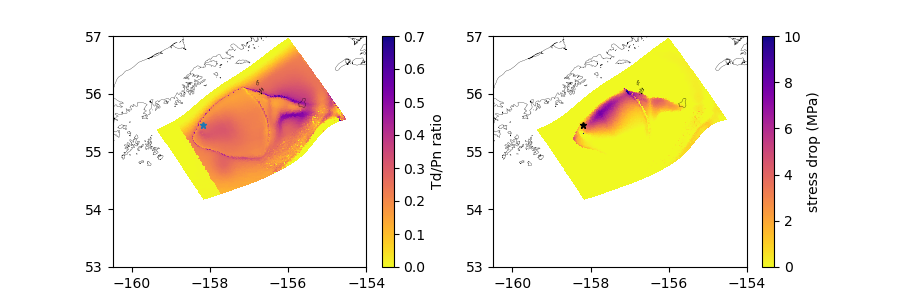

In [62]:
# plot residual shear stress
# ndt = 8

modelname = 'alkR057-TP72f'
# foldername = 'resultNew/'
xdmfFilename = foldername + modelname+'-fault.xdmf'

ndt = ReadNdt(xdmfFilename)-2

pn0 = LoadData(xdmfFilename,'Pn0',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
td0 = LoadData(xdmfFilename,'Td0',connect.shape[0],idt=0,oneDtMem=True,firstElement=-1)
td1 = LoadData(xdmfFilename,'Td0',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)


fig,([ax0,ax1])=plt.subplots(nrows=1,ncols=2,figsize=(9,3))

#ax0.set_title('Mapview of Td0')
# ax0.plot(hypoxyz[0]/1e3,hypoxyz[1]/1e3,'*w',markersize=3)
# ax0.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.3)
# ax0.set(xlim=(1.2e3, 1.75e3),ylim=(-2.2e3,-1.6e3))
# ax0.set_xticks([])
# ax0.set_yticks([])
ax0.plot(hypoll[5,0],hypoll[5,1],'*',markersize=5)
ax0.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.2)
ax0.set(xlim=(-160.5, -154),ylim=(53.5,57))
ax0.set_yticks([53,54,55,56,57])

sc = ax0.tripcolor(triang,-td1[0]/pn0[0],cmap='plasma_r',shading='flat',vmin=0.0,vmax=0.70)
cl = fig.colorbar(sc,ax=ax0)
cl.set_label('Td/Pn ratio')

# ax1.plot(hypoxyz[0]/1e3,hypoxyz[1]/1e3,'*w',markersize=3)
# ax1.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.3)
# ax1.plot(staloc[0:4,0]/1e3,staloc[0:4,1]/1e3,'*k',markersize=5)
# ax1.set_xticks([])
# ax1.set_yticks([])

# ax1.set(xlim=(1.2e3, 1.75e3),ylim=(-2.2e3,-1.6e3))
#ax1.set_title('Mapview of Mud')

sc = ax1.tripcolor(triang,(td0[0]-td1[0])/1e6,cmap='plasma_r',shading='flat',vmin=0.0,vmax=10.0)
cl = fig.colorbar(sc,ax=ax1)
cl.set_label('stress drop (MPa)')
ax1.plot(hypoll[5,0],hypoll[5,1],'*k',markersize=5)
ax1.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.2)
ax1.set(xlim=(-160.5, -154),ylim=(53.5,57))
ax1.set_yticks([53,54,55,56,57])

outname = modelname+'-resd.png'
plt.savefig(outname,dpi=200,transparent=False)

<IPython.core.display.Javascript object>


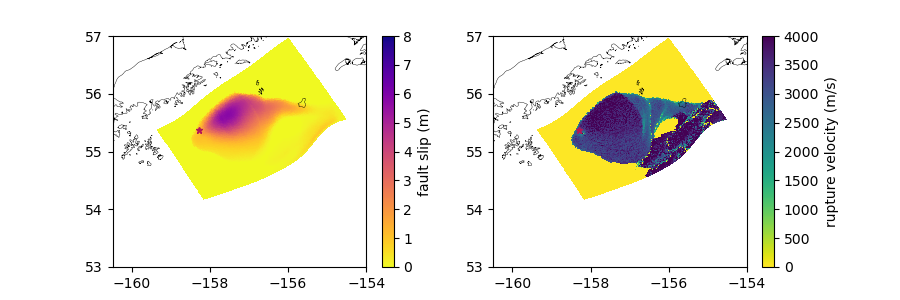

In [39]:
# plot result

# modelname = 'tp20q'
# foldername = 'result2/'

# modelname = 'tp20g'
# foldername = 'Shihao/'
# ndt = 50

staloc = np.loadtxt('vno_station_mesh3.xyz')

# xdmfFilename = foldername + modelname+'-fault.xdmf'
# ndt = ReadNdt(xdmfFilename)
# xyz = ReadGeometry(xdmfFilename)
# connect = ReadConnect(xdmfFilename)

# triang = tri.Triangulation(xyz[:,0]/1000,xyz[:,1]/1000,connect)

#%%
asl= LoadData(xdmfFilename,'ASl',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
vr =LoadData(xdmfFilename,'Vr',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)

fig,([ax0,ax1])=plt.subplots(nrows=1,ncols=2,figsize=(9,3))

#ax0.set_title('Mapview of Td0')
# ax0.plot(hypoxyz[0]/1e3,hypoxyz[1]/1e3,'*r',markersize=3)
# ax0.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.5)
# ax0.set(xlim=(1.2e3, 1.75e3),ylim=(-2.2e3,-1.6e3))
# ax0.set_xticks([])
# ax0.set_yticks([])

sc = ax0.tripcolor(triang,asl[0],cmap='plasma_r',shading='flat',vmin=0.0,vmax=8.0)
cl = fig.colorbar(sc,ax=ax0)
cl.set_label('fault slip (m)')
ax0.plot(hypoll[4,0],hypoll[4,1],'*',markersize=5,color=colors2[3])
ax0.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.3)
ax0.set(xlim=(-160.5, -154),ylim=(53.5,57))
ax0.set_yticks([53,54,55,56,57])


# ax1.plot(hypoxyz[0]/1e3,hypoxyz[1]/1e3,'*r',markersize=3)
# ax1.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.5)
# ax1.plot(staloc[0:4,0]/1e3,staloc[0:4,1]/1e3,'*k',markersize=5)
# ax1.set_xticks([])
# ax1.set_yticks([])

# ax1.set(xlim=(1.2e3, 1.75e3),ylim=(-2.2e3,-1.6e3))
#ax1.set_title('Mapview of Mud')

sc = ax1.tripcolor(triang,vr[0],cmap='viridis_r',shading='flat',vmin=0.0,vmax=4000.0)
cl = fig.colorbar(sc,ax=ax1)
cl.set_label('rupture velocity (m/s)')
ax1.plot(hypoll[4,0],hypoll[4,1],'*',markersize=5,color=colors2[3])
ax1.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.3)
ax1.set(xlim=(-160.5, -154),ylim=(53.5,57))
ax1.set_yticks([53,54,55,56,57])

outname = modelname+'-slp-vr.png'
plt.savefig(outname,dpi=200,transparent=False)

In [85]:
fsta=np.loadtxt('faultreceivers/faultreceiver1.txt')
fstaxyz =  pyproj.transform(myproj,lla,fsta[:,0],fsta[:,1],radians=False)
print(fstaxyz[0])
print(fstaxyz[1])

[-157.88970123 -157.2300004  -156.55500027 -156.52000025 -156.49000028]
[55.36334708 55.66666681 55.96166673 55.79833339 55.63666673]


/tmp/ipykernel_11419/3276987847.py:2: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  fstaxyz =  pyproj.transform(myproj,lla,fsta[:,0],fsta[:,1],radians=False)


<IPython.core.display.Javascript object>


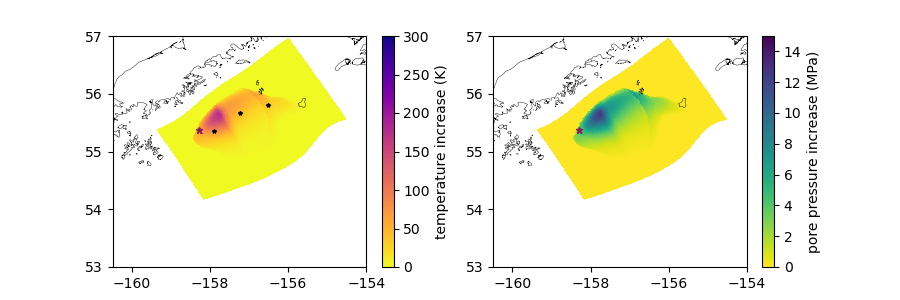

In [88]:
# plot tmp and pf

temp0 = 483.15

modelname = 'alkR057-TP72f'
# foldername = 'result3/'
xdmfFilename = foldername + modelname+'-fault.xdmf'

# ndt = ReadNdt(xdmfFilename)-2
# xyz = ReadGeometry(xdmfFilename)
connect = ReadConnect(xdmfFilename)

# hypoll = np.loadtxt('hypocenters.dat')
# hypoxyz =  pyproj.transform(lla, myproj,hypoll[:,0],hypoll[:,1],radians=False)

#%%
tmp= LoadData(xdmfFilename,'Tmp',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
pf =LoadData(xdmfFilename,'P_f',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)


fig,([ax0,ax1])=plt.subplots(nrows=1,ncols=2,figsize=(9,3))

#ax0.set_title('Mapview of Td0')
ax0.plot(fstaxyz[0][1],fstaxyz[1][1],'*k',markersize=3)
ax0.plot(fstaxyz[0][3],fstaxyz[1][3],'*k',markersize=3)
ax0.plot(fstaxyz[0][0],fstaxyz[1][0],'*k',markersize=3)


# ax0.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.5)
# ax0.set(xlim=(1.2e3, 1.75e3),ylim=(-2.2e3,-1.6e3))
# ax0.set_xticks([])
# ax0.set_yticks([])
ax0.plot(hypoll[4,0],hypoll[4,1],'*',color=colors2[2],markersize=5)
ax0.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.3)
ax0.set(xlim=(-160.5, -154),ylim=(53.5,57))
ax0.set_yticks([53,54,55,56,57])

sc = ax0.tripcolor(triang,tmp[0]-temp0,cmap='plasma_r',shading='flat',vmin=0.0,vmax=300.0)
cl = fig.colorbar(sc,ax=ax0)
cl.set_label('temperature increase (K)')

# ax1.plot(hypoxyz[0]/1e3,hypoxyz[1]/1e3,'*r',markersize=3)
# ax1.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.5)
# ax1.set(xlim=(1.2e3, 1.75e3),ylim=(-2.2e3,-1.6e3))
# ax1.set_xticks([])
# ax1.set_yticks([])

#ax1.set_title('Mapview of Mud')

sc = ax1.tripcolor(triang,-pf[0]/1e6,cmap='viridis_r',shading='flat',vmin=0.0,vmax=15.0)
cl = fig.colorbar(sc,ax=ax1)
cl.set_label('pore pressure increase (MPa)')
ax1.plot(hypoll[4,0],hypoll[4,1],'*',markersize=5,color=colors2[2])
ax1.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.3)
ax1.set(xlim=(-160.5, -154),ylim=(53.5,57))
ax1.set_yticks([53,54,55,56,57])

outname = modelname+'-pf-tmp.png'
plt.savefig(outname,dpi=100,transparent=False)

<IPython.core.display.Javascript object>


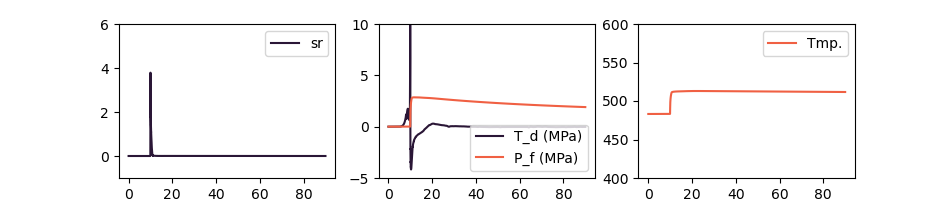

<IPython.core.display.Javascript object>


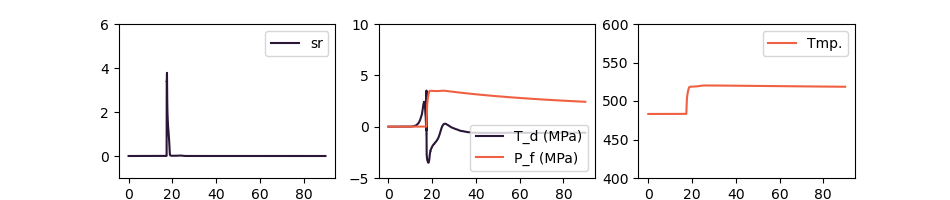

<IPython.core.display.Javascript object>


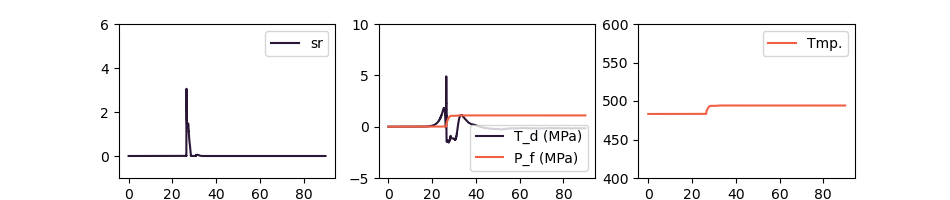

<IPython.core.display.Javascript object>


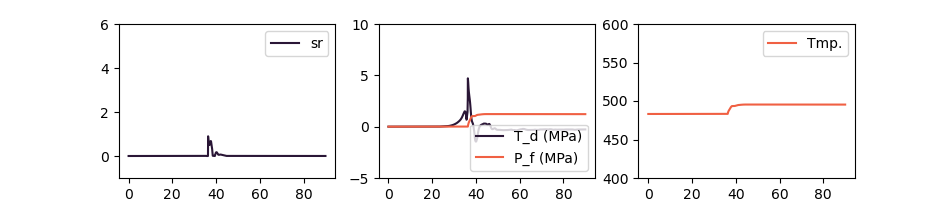

<IPython.core.display.Javascript object>


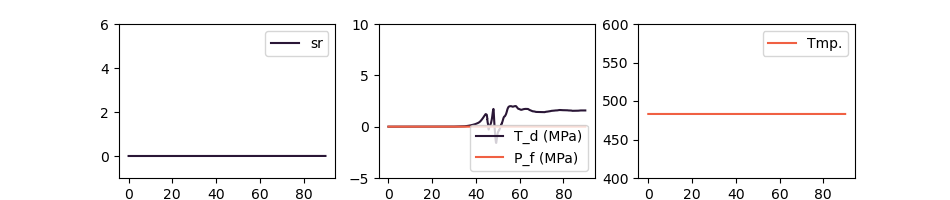

In [92]:
#plot fault receivers 

modelname = 'tp43'
icore = ['52','12','24']

modelname = 'tp22b'
icore = ['74','85','82']

modelname = 'tp27'
icore = ['47','07','24']

modelname = 'tp32'
icore = ['46','20','12']

modelname = 'tp33'
icore = ['18','95','51']

modelname = 'tp24a'
icore = ['97','41','27']

modelname = 'tp46'
icore = ['01','33','29']

modelname = 'tp47'
icore = ['02','36','46']

modelname = 'tp50'
icore = ['82','46','18']

modelname = 'tp20d'
icore = ['22','19','02']

foldername = 'result4/'
stanum = ['02','05','06']

modelname = 'tp20b'
icore = ['49','78','98']

modelname = 'tp20f'
icore = ['58','14','47']

modelname = 'tp20ii'
icore = ['10','36','34']


modelname = 'tp20l'
icore = ['34','80','79']



foldername = '/import/deadlock-data/dli/Alaska2021/resultNew/'
# stanum = ['02','05','06']
stanum = ['07','08','09','10','11']

modelname = 'alkR057-TP70a'
icore = ['095','089','050','053','070']

modelname = 'alkR057-TP72f'
icore = ['026','099','094','023','010']

for i in range(0,5):
    
    dd1 = np.loadtxt(foldername + modelname +'-faultreceiver-000'+ str(stanum[i])+'-00'+str(icore[i])+'.dat', comments='#',skiprows=2)

    #%% load data from unavco
    plt.figure(figsize=(9.5,2))

    ax1 = plt.subplot(131)
    plt.plot(dd1[:,0],dd1[:,2],color=colors2[0])
    plt.xlabel('time (s)')
    ax1.set(ylim=(-1,6))
    
    plt.legend(['sr'],loc=1)
    #     ax1.set_ylim([-0.6, 0.0])
    # ax1.set(xlim=([0, 180]))
#     plt.ylabel('slip rate (m/s)')
    # plt.title(station[i])

    ax2 = plt.subplot(132)
    #     plt.plot(dd0[:,1]-t0,dd0[:,2])
    plt.plot(dd1[:,0],dd1[:,4]/1e6,color=colors2[0])
    plt.plot(dd1[:,0],-dd1[:,19]/1e6,color=colors2[5])
    plt.xlabel('time (s)')
    ax2.set(ylim=(-5,10))


    plt.legend(['T_d (MPa)','P_f (MPa)'],loc=4)
    #     ax1.set_ylim([-0.6, 0.0])
    # ax1.set(xlim=([0, 180]))
#     plt.ylabel('traction (MPa)')
    # plt.title(station[i])

#     ax3 = plt.subplot(133)
#     #     plt.plot(dd0[:,1]-t0,dd0[:,2])
#     plt.plot(dd1[:,0],dd1[:,7],'b')
#     plt.plot(dd1[:,0],dd1[:,8],'r')
#     plt.legend(['M_u','state'],loc=1)
#     plt.xlabel('time (s)')
        
    ax4 = plt.subplot(133)
    #     plt.plot(dd0[:,1]-t0,dd0[:,2])
    plt.plot(dd1[:,0],dd1[:,20],color=colors2[5])
#     plt.plot(dd1[:,0],dd1[:,8],'r')
    plt.legend(['Tmp.'],loc=1)
    plt.xlabel('time (s)')
    ax4.set(ylim=(400,600))

    plt.savefig('fr_'+ modelname + '_' + stanum[i] +'.png',dpi=150)


In [139]:
# import instaseis
from obspy import read
from obspy.taup import TauPyModel as taup
from obspy.taup.taup_geo import calc_dist_azi as calc_dist_azi
from obspy.clients.fdsn import Client
from obspy.signal.cross_correlation import correlate
from obspy.signal.cross_correlation import xcorr_max


# plot regional seismic network and compare seismograph
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth
from obspy import UTCDateTime
from obspy.signal.rotate import rotate2zne
from obspy.core.stream import Stream
from obspy import read,read_inventory
# from obspy.signal.cross_correlation import xcorr
from obspy.signal.rotate import rotate_ne_rt
from obspy import Trace, Stream

cl_iris  = Client("IRIS")
nw = ['AK','AK']       # network
sta= ['CHN','S15K']      # station
ch = ['BN*','HN*']        # channel

# nw = ['AV','AV','AK','AK','AK']       # network
# sta= ['VNKR','DOL','S15K','CHN','R16K']  # station
# ch = ['EHZ','BHZ','HNZ','BHZ','BHZ']      # channel
# Event catalog
cat = cl_iris.get_events(minmagnitude=8.1,maxmagnitude=8.3, starttime=UTCDateTime(2021,7,28),endtime=UTCDateTime(2021,7,30)) # Y
event = cat[0]
print(cat)  

start = event.origins[0].time
end = start + 200

waveform = Stream()

for num in np.arange(len(sta)):
# for num in np.arange(1,2):
    if (num == 0):
        inv = cl_iris.get_stations(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end,level="response")
        inventory  = inv
        st = cl_iris.get_waveforms(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end)
    else:
        inv = cl_iris.get_stations(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end,level="response")
        inventory  += inv
        st = cl_iris.get_waveforms(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end)
    st.remove_response(inventory=inv,output='acc') 
    st.detrend('simple')
    waveform += st
#     print("Station %f: DONE " %(str(sta[num])))
print(waveform)

1 Event(s) in Catalog:
2021-07-29T06:15:49.188000Z | +55.364, -157.888 | 8.2  Mww
6 Trace(s) in Stream:
AK.CHN..BNE  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BNN  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BNZ  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.S15K..HNE | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S15K..HNN | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S15K..HNZ | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples


In [151]:
sta= ['CHN','S15K']
ch = ['BNE','BNN','BNZ']
ista = ['03','13']
ista = ['14','16']

modelname  = 'alkR057-TP60'
# icore = ['16','29'] # tp20
icore = ['19','85']

# modelname  = 'alkR057-TP64'
# icore = ['47','30']


waveform_syn = Stream()
for num in range(len(sta)):
    if num < 10:
        filename = foldername +modelname + '-receiver-000%s-000%s.dat'%(ista[num],icore[num])
#         if num == 0:
        t, vx, vy, vz = np.loadtxt(filename, comments='#', skiprows=2,usecols=(0,7,8,9),unpack=True)
        st = Stream([Trace(vx),Trace(vy),Trace(vz)])    
        for tr_num in range(3):
            st[tr_num].stats['sampling_rate'] = 200
            st[tr_num].stats['network'] = 'SeisSol'
            st[tr_num].stats['station'] = sta[num] 
            st[tr_num].stats['channel'] = ch[tr_num]
        waveform_syn += st


<IPython.core.display.Javascript object>


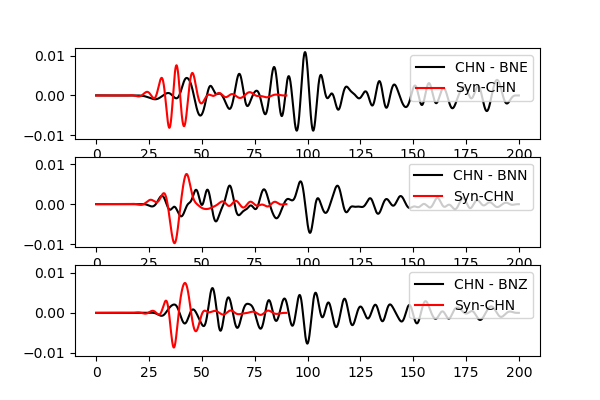

In [152]:
f1 = 0.01
f2 = 0.15

waveform_syn1 = waveform_syn.copy()
waveform_syn1.differentiate()
waveform_syn1.filter('bandpass',freqmin=f1,freqmax=f2, corners=4, zerophase=True)

waveform1 = waveform.copy()
waveform1.filter('bandpass',freqmin=f1,freqmax=f2, corners=4, zerophase=True)
            
num = 0 # Station CHN

plt.figure(figsize=(6, 4))

ax1 = plt.subplot(311)
ax1.plot(waveform1.select(station=sta[num],channel='BNE')[0].times(),waveform1.select(station=sta[num],channel='BNE')[0].data,'k',label='%s - BNE' %(sta[num]))
ax1.plot(waveform_syn1.select(channel='BNE')[0].times(),waveform_syn1.select(channel='BNE')[0].data,'r',label='Syn-%s' %(sta[num]))
ax1.legend()

ax2 = plt.subplot(312,sharey=ax1,sharex=ax1)
ax2.plot(waveform1.select(station=sta[num],channel='BNN')[0].times(),waveform1.select(station=sta[num],channel='BNN')[0].data,'k',label='%s - BNN' %(sta[num]))
ax2.plot(waveform_syn1.select(channel='BNN')[0].times(),waveform_syn1.select(channel='BNN')[0].data,'r',label='Syn-%s' %(sta[num]))
ax2.legend()

ax3 = plt.subplot(313,sharey=ax1,sharex=ax1)
ax3.plot(waveform1.select(station=sta[num],channel='BNZ')[0].times(),waveform1.select(station=sta[num],channel='BNZ')[0].data,'k',label='%s - BNZ' %(sta[num]))
ax3.plot(waveform_syn1.select(channel='BNZ')[0].times(),waveform_syn1.select(channel='BNZ')[0].data,'r',label='Syn-%s' %(sta[num]))
ax3.legend()

# ax3.set_xlabel('Time [s]')

plt.show()

outname = 'seismo_'+modelname+'_'+ sta[num] +'.png'
plt.savefig(outname,dpi=200,format='png',transparent=False)

<IPython.core.display.Javascript object>


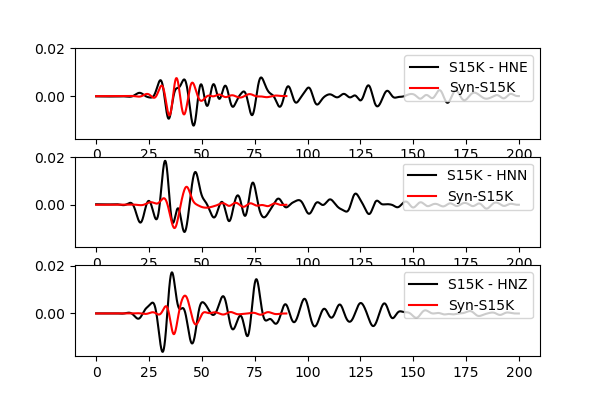

In [153]:
num = 1 # Station S15K

plt.figure(figsize=(6, 4))

ax1 = plt.subplot(311)
ax1.plot(waveform1.select(station=sta[num],channel='HNE')[0].times(),waveform1.select(station=sta[num],channel='HNE')[0].data,'k',label='%s - HNE' %(sta[num]))
ax1.plot(waveform_syn1.select(channel='BNE')[0].times(),waveform_syn1.select(channel='BNE')[0].data,'r',label='Syn-%s' %(sta[num]))
ax1.legend()

ax2 = plt.subplot(312,sharey=ax1)
ax2.plot(waveform1.select(station=sta[num],channel='HNN')[0].times(),waveform1.select(station=sta[num],channel='HNN')[0].data,'k',label='%s - HNN' %(sta[num]))
ax2.plot(waveform_syn1.select(channel='BNN')[0].times(),waveform_syn1.select(channel='BNN')[0].data,'r',label='Syn-%s' %(sta[num]))
ax2.legend()

ax3 = plt.subplot(313,sharey=ax1)
ax3.plot(waveform1.select(station=sta[num],channel='HNZ')[0].times(),waveform1.select(station=sta[num],channel='HNZ')[0].data,'k',label='%s - HNZ' %(sta[num]))
ax3.plot(waveform_syn1.select(channel='BNZ')[0].times(),waveform_syn1.select(channel='BNZ')[0].data,'r',label='Syn-%s' %(sta[num]))
ax3.legend()

# ax3.set_xlabel('Time [s]')

plt.show()
outname = 'seismo_'+modelname+'_'+ sta[num] +'.png'
plt.savefig(outname,dpi=200,format='png',transparent=False)

['001', '001', '085', '001', '001', '051']


<IPython.core.display.Javascript object>


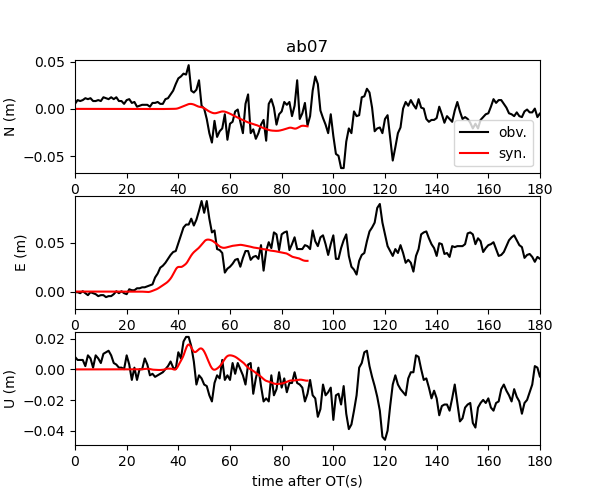

<IPython.core.display.Javascript object>


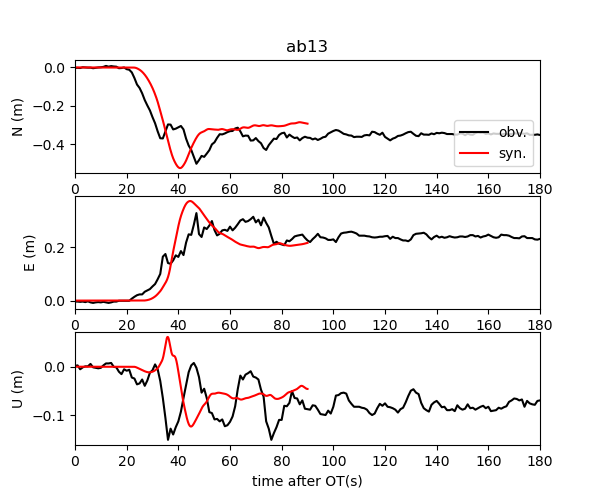

<IPython.core.display.Javascript object>


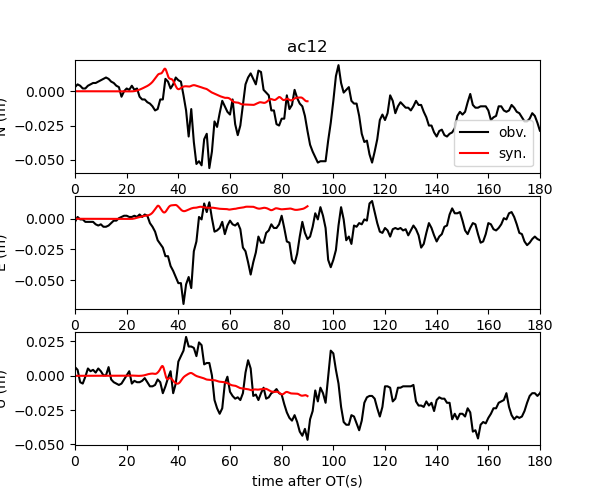

<IPython.core.display.Javascript object>


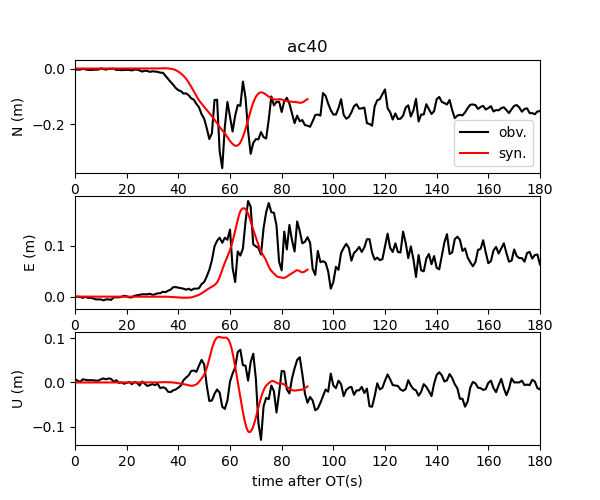

<IPython.core.display.Javascript object>


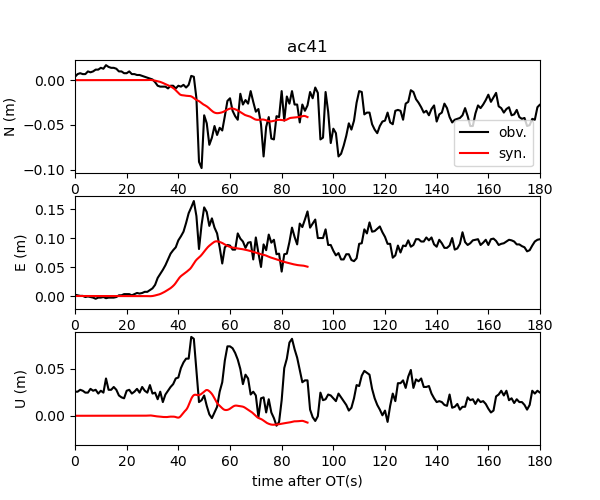

<IPython.core.display.Javascript object>


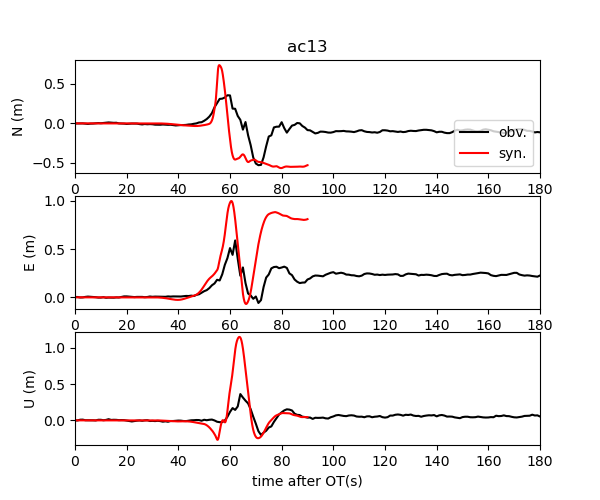

In [42]:
# plot 1hz gps displacement and compare for coarse surface mesh

# from datetime import date
# print(date.toordinal(date(2021,7,29)))

# modelname = 'tp15'
# foldername = 'result1/'

# stanum = ['17','01','18','13','05']
# icore = ['52','95','55','95','52']

foldername = 'resultNew/'
foldername = '/import/deadlock-data/dli/Alaska2021/resultNew/'

station = ['ab13','ac12','ac40','ac41']
stanum = ['02','18','13','05']

modelname = 'tp20'
icore = ['16','29','16','29','16']

modelname = 'tp22'
icore = ['01','55','01','55','01']

modelname = 'tp20o'
icore = ['67','67','67','67','67']

modelname = 'tp20o2'
icore = ['01','137','076','067','081']

modelname = 'tp20c'
icore = ['001','039','046','039','081']

modelname = 'alkR057-TP20'
icore = ['020','079','020','020']

modelname = 'alkR057-TP37'
icore = ['019','019','032','055']

modelname = 'alkR057-TP45'
icore = ['010','010','014','010','010']

modelname = 'alkR057-TP48'
icore = ['001','027','044','066','001','086']

modelname = 'alkR057-TP49'
icore = ['072','063','093','072','072','043']

modelname = 'alkR057-TP55'
icore = ['013','013','047','013','013','043']

modelname = 'alkR057-TP60'
icore = ['029','085','019','085','029','071']

modelname = 'alkR057-TP51'
icore = ['071','086','057','032','071','031']


modelname = 'alkR057-TP64'
icore = ['030','030','047','030','030','079']

modelname = 'alkR057-TP64f'
icore = ['007','007','007','054','007','086']


modelname = 'alkR057-TP72d'
icore = ['001','001','085','001','001','051']


# modelname = 'alkR057-TP54'
# icore = ['027','026','027']

# station = ['ab07','ac12','ac41']
# stanum = ['01','03','05']

station = ['ab07','ab13','ac12','ac40','ac41','ac13']
stanum = ['01','02','03','04','05','19']

year = '2021'
doy = '210'

print(icore)
    
for i in range(0,6):
    dd1 = np.loadtxt(foldername +modelname+'-receiver-000'+ str(stanum[i])+'-00'+str(icore[i])+'.dat', comments='#',skiprows=2)

    #%% load data from unavco
    # station = 'ab13'
    
#     dd0 = np.loadtxt('/import/freenas-m-05-seissol/dli/SNIVEL/output/velocities_'+ station[i] +'_'+ doy + '_'+ year +'.txt', comments='#',skiprows=1)
#     t0 = dd0[0,1] # OT
    
    dd0 = np.loadtxt('/import/freenas-m-05-seissol/dli/Alaska2021/GPS/enu_2021210_'+ station[i])
    t0 = 22567 # OT in gps displacement data from K. Wang.
    
#     stream ='st_'+station[i] 
#     tr1 = Trace(data=dd0[:,2]-np.mean(dd0[0:666,2]))
#     tr2 = Trace(data=dd0[:,3]-np.mean(dd0[0:666,3]))
#     tr3 = Trace(data=dd0[:,4]-np.mean(dd0[0:666,4]))
  
#     tr1.stats.delta=1.0
#     tr1.stats.starttime=dd0[0,1]
#     tr2.stats.delta=1.0
#     tr2.stats.starttime=dd0[0,1]
#     tr3.stats.delta=1.0
#     tr3.stats.starttime=dd0[0,1]
    
#     stream = Stream(traces=[tr1, tr2,tr3])
    
    ##
    plt.figure(figsize=(6,5))
    
    ax1 = plt.subplot(311)
#     plt.plot(dd0[:,1]-t0,dd0[:,2])
    plt.plot(dd0[:,1]-t0,dd0[:,3]-np.mean(dd0[0:666,3]),'k')
#     plt.plot(stream[0].times(),stream[0].data)
    plt.plot(dd1[:,0],0.005*np.cumsum(dd1[:,8]),'r')

    plt.legend(['obv.','syn.'],loc=4)
#     ax1.set_ylim([-0.6, 0.0])
    ax1.set(xlim=([0, 180]))
    plt.ylabel('N (m)')
    plt.title(station[i])

    ax2 = plt.subplot(312,sharex=ax1)
    plt.plot(dd0[:,1]-t0,dd0[:,2]-np.mean(dd0[0:666,2]),'k')
#     plt.plot(stream[0].times(),stream[1].data)
    plt.plot(dd1[:,0],0.005*np.cumsum(dd1[:,7]),'r')
#     plt.legend([station[i]+' ', 'syn.'],loc=4)
#     plt.ylim([0.0, 0.5])
#     plt.xlim([0, 180])
    plt.ylabel('E (m)')

    ax3 = plt.subplot(313,sharex=ax1)
    plt.plot(dd0[:,1]-t0,dd0[:,4]-np.mean(dd0[0:666,4]),'k')
#     plt.plot(stream[0].times(),stream[2].data)
    plt.plot(dd1[:,0],0.005*np.cumsum(dd1[:,9]),'r')
#     plt.legend([station[i]+' ', 'syn.'],loc=4)
#     plt.ylim([-0.0, 0.7])
#     plt.xlim([0, 180])
    plt.xlabel('time after OT(s)')
    plt.ylabel('U (m)')
        # plt.ylim(-350000,350000)      
    plt.savefig('disp_'+ modelname + '_' + station[i] +'.png',dpi=150)

In [130]:
from obspy.core.trace import Trace

foldername = 'resultNew/'
foldername = '/import/deadlock-data/dli/Alaska2021/resultNew/'

modelname = 'alkR057-TP45'
icore = ['010','010','014','010','010']

station = ['ab07','ab13','ac12','ac40','ac41']
stanum = ['01','02','03','04','05']

year = '2021'
doy = '210'

print(icore)
    
for i in range(0,5):
    
    dd0 = np.loadtxt('/import/freenas-m-05-seissol/dli/SNIVEL/output/velocities_'+ station[i] +'_'+ doy + '_'+ year +'.txt', comments='#',skiprows=1)
    t0 = dd0[0,1] # OT
    
    dd0 = np.loadtxt('/import/freenas-m-05-seissol/dli/Alaska2021/GPS/enu_2021210_'+ station[i])
    t0 = 22567 # OT in gps displacement data from K. Wang.
    
    stream ='st_'+station[i] 
    tr1 = Trace(data=dd0[:,2]-np.mean(dd0[0:666,2]))
    tr2 = Trace(data=dd0[:,3]-np.mean(dd0[0:666,3]))
    tr3 = Trace(data=dd0[:,4]-np.mean(dd0[0:666,4]))
  
    tr1.stats.delta=1.0
    tr1.stats.starttime=dd0[0,1]
    tr2.stats.delta=1.0
    tr2.stats.starttime=dd0[0,1]
    tr3.stats.delta=1.0
    tr3.stats.starttime=dd0[0,1]
    
    stream = Stream(traces=[tr1, tr2,tr3])
    
    print(dd0[:,2],tr2.data,stream[1].data)
 

['010', '010', '014', '010', '010']
[-0.018 -0.019 -0.019 ...  0.025  0.026  0.026] [ 0.003  0.003  0.002 ... -0.006 -0.01  -0.005] [ 0.003  0.003  0.002 ... -0.006 -0.01  -0.005]
[-0.099 -0.1   -0.101 ...  0.131  0.134  0.135] [ 0.148  0.147  0.144 ... -0.2   -0.199 -0.201] [ 0.148  0.147  0.144 ... -0.2   -0.199 -0.201]
[ 0.005  0.006  0.005 ... -0.013 -0.012 -0.011] [ 0.007  0.005  0.008 ... -0.001 -0.007 -0.007] [ 0.007  0.005  0.008 ... -0.001 -0.007 -0.007]
[-0.034 -0.034 -0.033 ...  0.051  0.048  0.045] [ 0.06   0.059  0.058 ... -0.08  -0.08  -0.083] [ 0.06   0.059  0.058 ... -0.08  -0.08  -0.083]
[-0.047 -0.046 -0.046 ...  0.059  0.058  0.055] [ 0.02   0.017  0.02  ... -0.024 -0.024 -0.022] [ 0.02   0.017  0.02  ... -0.024 -0.024 -0.022]


In [86]:
print(dd0[:,0])

[59424. 59424. 59424. ... 59424. 59424. 59424.]


In [16]:
#%% Teleseismic comparision for model results

folder = '/import/freenas-m-05-seissol/dli/Alaska2021/tele/'
# event
# strike, dip, rake
event_time = obspy.UTCDateTime(2021,7,29,6,15,49)
plane = np.array([239, 14, 95])

## hypocenter
elat = 55.364 
elon = -157.888

## station locations
# sta = np.loadtxt(folder + 'stations.txt')
sta = np.loadtxt(folder + 'stations_D40_60.txt');

slat = sta[:,0]
slon = sta[:,1]

print(len(slat))

db = instaseis.open_db("syngine://iasp91_2s") # downloaded IRIS mseed data
# load IRIS miniseed 
#seisdata = read(folder + '2014-04-18-mw73-guerrero-mexico-2.miniseed')

# info = calc_dist_azi(elat, elon, slat[0],slon[0],6370,0)
# print(info)

19


In [53]:
# TEST get iris data 
fdsn_client = Client('IRIS')
# event_time = obspy.UTCDateTime(2014,4,18,14,27,24)
ptime = 710.39
# sta = ['KBS','TARA','CMLA','HOPE','KDAK','FFC']

st = fdsn_client.get_waveforms(network='IU', station='ANMO', location='00',
                               channel='BH*', starttime=event_time+ptime-60, endtime=event_time+ptime+120,
                               attach_response=True)

inv = fdsn_client.get_stations(network="I*", station='ANMO',location='00', channel='BH*', level='channel',
                               starttime=event_time+ptime-60, endtime=event_time+ptime+120)
    
pre_filt = (0.005, 0.1, 30.0, 35.0)
st.remove_response(output='VEL', pre_filt=pre_filt)
st.rotate(method="->ZNE", inventory=inv) 

# print(st.select(channel="BHE")[0].times())
# print(st.select(channel="BHE")[0].data)
# print(st[0].stats)

inv.plot(projection="global", label=False,
         color_per_network=True) 

NameError: name 'Client' is not defined

In [52]:
stadata = pandas.read_csv(folder+'stations_D40_60_name.csv')
stalist = stadata["name"]
print(len(stalist))

for ista in range(0,len(stalist)):
#     taup get arrival time
    
    station = stalist[ista]
    print(station)
    net = 'IU'
    model = taup(model="iasp91")
    source_to_receiver = calc_dist_azi(elat, elon, slat[ista],slon[ista],6371,0)
    dist = round(source_to_receiver[0],2)
    azi  = round(source_to_receiver[1],2)
    
    arrivals = model.get_travel_times(source_depth_in_km=24,distance_in_degree=dist,phase_list=["P"])
    ptime = arrivals[0].time
    print(arrivals)
    
#     load data from IRIS
    
    seisdata = fdsn_client.get_waveforms(network = net, station = station, location = '00',
                               channel = 'BH*', starttime = event_time+ptime-60, endtime = event_time+ptime+120,
                               attach_response = True)
    starttime = seisdata.select(station=station,channel="BHZ")[0].stats.starttime
    
    inv = fdsn_client.get_stations(network=net, station=station,location='00', channel='BH*', level='channel',
                               starttime=event_time+ptime-60, endtime=event_time+ptime+120)
    seisdata.rotate(method="->ZNE", inventory=inv)   
    seisdata.rotate(method="NE->RT",back_azimuth=azi) 
    seisdata.resample(20.0)
#     print(seisdata)
    
#     using Instaseis to calculate seismograph
    receiver = instaseis.Receiver(latitude=slat[ista],longitude=slon[ista],network=net, station=station)
    source = instaseis.Source.from_strike_dip_rake(latitude=elat,longitude=elon,depth_in_m=24000.0,strike=plane[0],dip=plane[1],rake=plane[2],M0=9.4e19,origin_time=event_time)

    seismo0 = db.get_seismograms(source=source,receiver=receiver,dt=0.05,kind='velocity',components=('Z','N','E'))
    seismo0.filter('bandpass', freqmax=0.1, freqmin=0.005, corners=4, zerophase=True)
    seismo0.trim(starttime = event_time+ptime-60,endtime=event_time+ptime+120,nearest_sample=True)
    seismo0.taper(max_percentage=0.1)
    seismo0.rotate(method="NE->RT",back_azimuth=azi) 
#     print(seismo0)
            
    norm11 = np.max(seismo0.select(channel='BXZ')[0].data)
    norm12 = np.max(seismo0.select(channel='BXR')[0].data)
    norm13 = np.max(seismo0.select(channel='BXT')[0].data)
    norm1 = np.max([norm11,norm12,norm13])

#     IRIS data bandbass filter
    pre_filt = (0.005, 0.1, 30.0, 35.0)
    seisdata.remove_response(output='VEL', pre_filt=pre_filt)
    seisdata.filter('bandpass', freqmax=0.1, freqmin=0.005, corners=4, zerophase=True)    
    seisdata.taper(max_percentage=0.05)
    
    norm21 = np.max(seisdata.select(channel='BHZ')[0].data)
    norm22 = np.max(seisdata.select(channel='BHR')[0].data)
    norm23 = np.max(seisdata.select(channel='BHT')[0].data)
    norm2 = np.max([norm21,norm22,norm23])
    
    cc = correlate(seismo0.select(channel='BXZ')[0].data,seisdata.select(channel='BHZ')[0].data,600)
#     cc = correlate(seismo0[0].data,np.roll(seismo0[0].data,20),200)
    
    shift, value = xcorr_max(cc,abs_max=False)
    print(shift, value)   
    
    #     figure of comparison of synthetic and observation data
    fig,([ax0,ax1,ax2]) = plt.subplots(nrows=1,ncols=3,figsize=(12,2.0))

    ax0.plot(seismo0.select(channel='BXZ')[0].times(),seismo0.select(channel='BXZ')[0].data/norm1,'r')
    ax0.set_title('Z ')
    ax0.set_ylabel(station+' (' + str(dist)+','+str(azi)+')')
    ax0.set_ylim(-1,1)
    ax0.set_yticks([])
    ax0.plot(seisdata.select(channel='BHZ')[0].times(),np.roll(seisdata.select(channel='BHZ')[0].data/norm2,int(shift)),'k')
#     ax0.text(100,0.8, ,fontsize=12)

    ax1.plot(seismo0.select(channel='BXR')[0].times(),seismo0.select(channel='BXR')[0].data/norm1,'r')
    ax1.set_title('R ')
    ax1.set_ylim(-1,1)
    ax1.set_yticks([])
    ax1.plot(seisdata.select(channel='BHR')[0].times(),np.roll(seisdata.select(channel='BHR')[0].data/norm2,int(shift)),'k')
#     ax1.text(150,0.8,'cc='+str(shift*seisdata.select(channel='BHZ')[0].stats.delta),fontsize=12)

    ax2.plot(seismo0.select(channel='BXT')[0].times(),seismo0.select(channel='BXT')[0].data/norm1,'r')
    ax2.set_title('T ')
    ax2.set_ylim(-1,1)
    ax2.set_yticks([])
    ax2.plot(seisdata.select(channel='BHT')[0].times(),np.roll(seisdata.select(channel='BHT')[0].data/norm2,int(shift)),'k')
#     ax2.text(150,0.8,'cc='+str(shift*seisdata.select(channel='BHZ')[0].stats.delta),fontsize=12)

    plt.show()
    outname = 'tele/seismo_'+station+'_'+net+'.eps'
    plt.savefig(outname,dpi=100,format='eps',transparent=False)

print('finished')

NameError: name 'pandas' is not defined

In [51]:
stadata = pandas.read_csv(folder+'stations_D40_60_name.csv')
# stadata["name"]

# print(seismo0.select(channel='BXZ')[0])
# print(seisdata.select(channel='BHZ')[0])

NameError: name 'pandas' is not defined

In [ ]:
#%% load IRIS mseed data
# fdsn_client = Client('IRIS')
# event_time = obspy.UTCDateTime(2014,4,18,14,27,24)

# st = fdsn_client.get_waveforms(network='II', station='CMLA', location='00',
#                                channel='BHZ', starttime=event_time+ptime-60, endtime=event_time+ptime+120,
#                                attach_response=True)

# pre_filt = (0.005, 0.006, 30.0, 35.0)
# st.remove_response(output='VEL', pre_filt=pre_filt)

# st.plot()

In [30]:
## plot parameters d_c

centers = (xyz[connect[:,0]] + xyz[connect[:,1]] + xyz[connect[:,2]])/3.

r = np.sqrt(np.power(centers[:,0]-1460401.0,2.0)+np.power(centers[:,1]+1929593.0,2.0)+np.power(centers[:,2]+25956.0,2.0));
r_crit0 = 5000.0;
r_crit = 10000.0;
a = (r-r_crit0)/r_crit

alpha1 = np.where(a<1.0,a,1.0)
alpha = np.where(alpha1>0.0,alpha1,0.0)

rs_l0 = 0.2-0.1*alpha
dd = np.where(r>105000.0)

rs_l0[dd] = 0.8 

fig,ax0 = plt.subplots(ncols=1,nrows=1,figsize=(6,3.5))
sc = ax0.tripcolor(triang,rs_l0,cmap='plasma',shading='flat');
ax0.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.2)
ax0.set(xlim=(-160.5, -154),ylim=(53.5,57))
cl = fig.colorbar(sc,ax=ax0,shrink=0.75)
cl.set_label('dc (m)')
ax0.plot(hypoll[4,0],hypoll[4,1],'*',markersize=5,color=colors2[3])

outname = './'+ modelname +'-dc.png'
plt.savefig(outname,dpi=150,transparent=False)

IndexError: index 90 is out of bounds for axis 0 with size 0

<IPython.core.display.Javascript object>


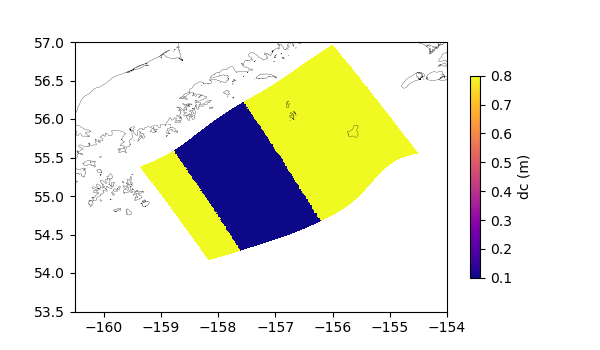

In [17]:
## plot parameters d_c segments and TP parameters segment

centers = (xyz[connect[:,0]] + xyz[connect[:,1]] + xyz[connect[:,2]])/3.

ac = 2.85
bc = 1
cc = -2.05e6
yx = ac * centers[:,0]+ bc*centers[:,1] + cc

rs_l0 = np.zeros(yx.shape)+0.1

dd = np.where(yx<0.05e6)
rs_l0[dd] = 0.8

dd = np.where(yx>0.38e6)
rs_l0[dd] = 0.8

fig,ax0 = plt.subplots(ncols=1,nrows=1,figsize=(6,3.5))
sc = ax0.tripcolor(triang,rs_l0,cmap='plasma',shading='flat');
ax0.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.2)
ax0.set(xlim=(-160.5, -154),ylim=(53.5,57))
cl = fig.colorbar(sc,ax=ax0,shrink=0.75)
cl.set_label('dc (m)')
ax0.plot(hypoll[4,0],hypoll[4,1],'*',markersize=5,color=colors2[1])

outname = './'+ modelname +'-segment.png'
plt.savefig(outname,dpi=150,transparent=False)

In [1]:
## plot parameters d_c segments and TP parameters segment

centers = (xyz[connect[:,0]] + xyz[connect[:,1]] + xyz[connect[:,2]])/3.

ac = 2.85
bc = 1
cc = -2.05e6
yx = ac * centers[:,0]+ bc*centers[:,1] + cc

alpha = np.zeros(yx.shape)+1e-5
wf_l0 = np.zeros(yx.shape)+0.035


dd = np.where(yx<0.05e6)
alpha[dd] = 1e-8
wf_l0[dd]=0.1

dd = np.where(yx>0.25e6)
alpha[dd] = 1e-8
wf_l0[dd] = 0.1

fig,([ax0,ax1]) = plt.subplots(ncols=2,nrows=1,figsize=(9,3.5))
sc = ax0.tripcolor(triang,alpha,cmap='viridis',shading='flat');
ax0.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.2)
ax0.set(xlim=(-160.5, -154),ylim=(53.5,57))
cl = fig.colorbar(sc,ax=ax0,shrink=0.75)
cl.set_label('alpha_hy (m^2/s)')
ax0.plot(hypoll[4,0],hypoll[4,1],'*',markersize=5,color=colors2[1])

sc = ax1.tripcolor(triang,wf_l0,cmap='viridis',shading='flat');
ax1.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.2)
ax1.set(xlim=(-160.5, -154),ylim=(53.5,57))
cl = fig.colorbar(sc,ax=ax1,shrink=0.75)
cl.set_label('Wf (m)')


outname = './'+ modelname +'-alpha_hy_Wf.png'
plt.savefig(outname,dpi=200,transparent=False)

NameError: name 'xyz' is not defined

<IPython.core.display.Javascript object>


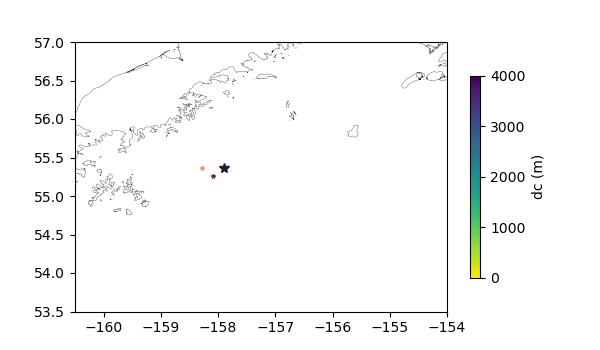

In [99]:

hypo2 = np.loadtxt('hypocenters2.dat')
hypo = np.loadtxt('hypocenters.dat')


fig,ax0 = plt.subplots(ncols=1,nrows=1,figsize=(6,3.5))

ax0.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.2)
ax0.set(xlim=(-160.5, -154),ylim=(53.5,57))
cl = fig.colorbar(sc,ax=ax0,shrink=0.75)
cl.set_label('dc (m)')
ax0.plot(hypo[4,0],hypo[4,1],'*',markersize=3,color=colors2[6])
ax0.plot(hypo[0,0],hypo[0,1],'*',markersize=7,color=colors2[0])
ax0.plot(hypo2[3,0],hypo2[3,1],'*',markersize=3,color=colors2[2])

# ax0.plot(hypo[5,0],hypo[5,1],'*',markersize=5,color=colors2[2])
# ax0.plot(hypo[4,0],hypo[4,1],'*',markersize=5,color=colors2[3])
# ax0.plot(hypo[6,0],hypo[6,1],'*',markersize=5,color=colors2[1])


outname = './'+ modelname +'-hypo.png'
plt.savefig(outname,dpi=150,transparent=False)

In [ ]:
### plot a-b profile
dep = np.array([-5e3,10e3,12e3,36e3,40e3,100e3])
abpro=np.array([0.02,0.02,0.01,0.01,0.02,0.02])

fig,ax0=plt.subplots(ncols=1,nrows=1,figsize=(4,4))
ax0.plot(abpro,-dep,'-',c='k')
ax0.plot([0.014,0.014],[5e3,-100e3],'-',c='red')
ax0.legend(['a-b','b'])
               
plt.savefig('abprofile.png',dpi=200)               

<IPython.core.display.Javascript object>


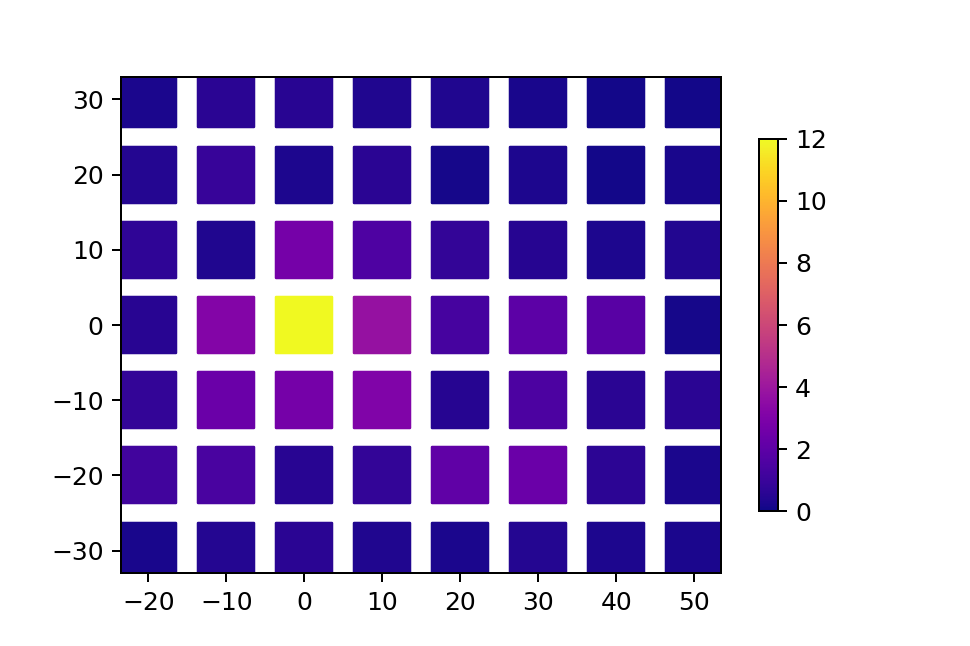

In [20]:
#%% Ye 2016 

stress = np.loadtxt(folder + 'stress_drop.txt',comments='#')

fig,ax0= plt.subplots(nrows=1,ncols=1,figsize=(3,2))

sc = ax0.scatter(stress[:,0],stress[:,1],s=500,c=stress[:,3],marker='s',cmap='plasma',vmin=0,vmax=12)
cl = fig.colorbar(sc,ax=ax0,shrink=0.75)

plt.show()


In [ ]:
print('finished')